In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold

import torch
import torch.distributions as D

from clusterless.utils import NP1DataLoader, ADVIDataLoader, fit_initial_gmm
# from clusterless.encoder import CAVI
from clusterless.decoder import static_decoder

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [3]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### load data

In [4]:
# np1_data_loader = NP1DataLoader(
#     probe_id = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0', 
#     geom_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016/np1_channel_map.npy', 
#     ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016/subtraction_results_threshold_5', 
#     behavior_path = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/original_data'
# )

In [5]:
np1_data_loader = NP1DataLoader(
    probe_id = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943', 
    geom_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/np1_channel_map.npy', 
    ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/subtraction_results_threshold_5', 
    # ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/subtract_res_wf_pcs', 
    behavior_path = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/original_data'
)

Session ID: db4df448-e449-4a6f-a0e7-288711e7a75a
Probe ID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 (probe00)
First trial stimulus onset time: 40.81 sec
Last trial stimulus onset time: 2252.10 sec


In [6]:
region = 'lp'

In [7]:
# trials = np1_data_loader.load_spike_features(region = 'vis')

In [8]:
trials = np1_data_loader.relocalize_kilosort(
    data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/kilosort_localizations',
    region = region)

Found 38 channels in region lp


In [9]:
trials[-1].max(0)

array([2253.09975431,  204.        ,  117.95987005, 2064.23401934,
         26.34952545])

In [10]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories_, rewards, priors = \
    np1_data_loader.load_behaviors('static')

Choices left: 0.361, right: 0.639
Stimuli left: 0.430, right: 0.570
Reward wrong: 0.087, correct: 0.913


In [11]:
advi_data_loader = ADVIDataLoader(
                         data = trials, 
                         behavior = choices.argmax(1), 
                         n_t_bins = 30)

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
kf_train_ids = []
kf_test_ids = []
for i, (train_ids, test_ids) in enumerate(kf.split(advi_data_loader.behavior)):
    kf_train_ids.append(train_ids)
    kf_test_ids.append(test_ids)

In [13]:
i = 0
train_trials, train_trial_ids, train_time_ids, test_trials, test_trial_ids, test_time_ids = \
    advi_data_loader.split_train_test(kf_train_ids[i], kf_test_ids[i])

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [14]:
train_trials.max(0)

array([ 206.        ,  159.        , 2089.1279605 ,   34.28616333])

In [15]:
gmm = fit_initial_gmm(np.concatenate(trials)[:,1:])

/home/yizi/isosplit/isosplit/parcelate2.py:73: RuntimeWarning: Mean of empty slice.
  X[:, jinds].mean(axis=1, keepdims=True)
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


#### ADVI

In [16]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

In [17]:
class ADVI(torch.nn.Module):
    def __init__(self, Nk, Nt, Nc, Nd, init_means, init_covs):
        super(ADVI, self).__init__()
        self.Nk = Nk
        self.Nt = Nt
        self.Nc = Nc
        self.Nd = Nd
        
        # initialize variables for variational distribution
        self.means = torch.nn.Parameter(torch.tensor(init_means), requires_grad=False)
        self.covs = torch.nn.Parameter(torch.tensor(init_covs), requires_grad=False)
        self.b_mu = torch.nn.Parameter(torch.randn((Nc)))
        self.b_log_sig = torch.nn.Parameter(torch.randn((Nc)))
        self.beta_mu = torch.nn.Parameter(torch.randn((Nc, Nt)))
        self.beta_log_sig = torch.nn.Parameter(torch.randn((Nc, Nt)))
        
    def log_prior_plus_logabsdet_J(self, b_sample, beta_sample):
        
        # log prior for beta, evaluated at sampled values for beta
        lp_b = D.Normal(torch.zeros((self.Nc)), torch.ones((self.Nc))).log_prob(b_sample).sum()

        # log prior sig + log jacobian
        lp_beta = D.Normal(torch.zeros((self.Nc, self.Nt)), torch.ones((self.Nc, self.Nt))).log_prob(beta_sample).sum()
        
        return lp_b + lp_beta
    
    
    def log_q(self, b_sample, beta_sample):
        
        lq_b = self.b.log_prob(b_sample).sum()

        lq_beta = self.beta.log_prob(beta_sample).sum()
        
        return lq_b + lq_beta
        
        
    def forward(self, s, y, ks, ts, sampling=True):
        
        # define global variational parameters
        self.b = D.Normal(self.b_mu, self.b_log_sig.exp())
        self.beta = D.Normal(self.beta_mu, self.beta_log_sig.exp())
        
        # sample from the variational distributions
        if sampling:
            b_sample = self.b.rsample()
            beta_sample = self.beta.rsample()
        else:
            b_sample = self.b.loc
            beta_sample = self.beta.loc
                    
        # mixing proportions 
        log_lambdas = torch.zeros((self.Nk, self.Nc, self.Nt))
        for k in range(self.Nk):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = b_sample + beta_sample[:,t] * y[k]
        log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]
                                          
                                          
        # compute log-likelihood
        ll = torch.zeros((s.shape[0], self.Nc))
        for j in range(self.Nc):
            ll[:,j] = D.multivariate_normal.MultivariateNormal(
                            loc=self.means[j], 
                            covariance_matrix=self.covs[j]
                        ).log_prob(s)
            
        
        # compute local variational parameters
        r = torch.zeros((s.shape[0], self.Nc))
        for k in range(self.Nk):
            for t in range(self.Nt):
                k_t_idx = torch.logical_and(ks == torch.unique(ks).int()[k], ts == t)
                r[k_t_idx] = torch.exp( ll[k_t_idx] + log_pis[k,:,t] )
                r[k_t_idx] = r[k_t_idx] / r[k_t_idx].sum(1)[:,None]
                            
                                          
        # compute ELBO
        elbo = 0
        for k in range(self.Nk):
            for t in range(self.Nt):
                k_t_idx = torch.logical_and(ks == torch.unique(ks).int()[k], ts == t)
                elbo += torch.sum( r[k_t_idx] * ll[k_t_idx] )
                elbo += torch.sum( r[k_t_idx] * log_pis[k,:,t] )
                elbo -= torch.sum( r[k_t_idx] * safe_log(r[k_t_idx]) )
                
        elbo += self.log_prior_plus_logabsdet_J(b_sample, beta_sample)
        elbo -= self.log_q(b_sample, beta_sample)                                  
        
        return elbo
    
    
    def train_advi(self, s, y, ks, ts, batch_ids, optim, max_iter):
        '''
        
        '''
        elbos = []
        N = s.shape[0]
        for i in range(max_iter):
            tot_elbo = 0
            for n, batch_idx in enumerate(batch_ids): 
                mask = torch.logical_and(ks >= batch_idx[0], ks <= batch_idx[-1])
                batch_s = s[mask]
                batch_y = y[list(batch_idx)]
                batch_ks = ks[mask]
                batch_ts = ts[mask]
                loss = - self(batch_s, batch_y, batch_ks, batch_ts) / N
                loss.backward()
                tot_elbo -= loss.item()
                if (n+1) % 100 == 0:
                    print(f'iter: {i+1} batch {n+1}')
                optim.step()
                optim.zero_grad()
            print(f'iter: {i+1} total elbo: {tot_elbo:.2f}')
            elbos.append(tot_elbo)
        elbos = [elbo for elbo in elbos]
        return elbos
    
    
    def calc_dynamic_mixing_proportions(self, y):
        '''
        
        '''
        log_lambdas = torch.zeros((len(y), self.Nc, self.Nt))
        for k in range(len(y)):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = self.b.loc + self.beta.loc[:,t] * y[k]

        log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]
        return log_pis.exp().detach().numpy()
    
    
    def encode_gmm(self, data, train, test, y_train, y_pred):
        
        Nk = len(train) + len(test)
        log_lambdas = np.zeros((Nk, self.Nc, self.Nt))
        for i, k in enumerate(train):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = self.b.loc.detach().numpy() + \
                                     self.beta.loc[:,t].detach().numpy() * y_train[i]

        for i, k in enumerate(test):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = self.b.loc.detach().numpy() + \
                                     self.beta.loc[:,t].detach().numpy() * y_pred[i]

        log_pis = log_lambdas - logsumexp(log_lambdas, 1)[:,None,:]
        encoded_pis = np.exp(log_pis)
        
        encoded_weights = np.zeros_like(log_lambdas)
        for k in range(encoded_weights.shape[0]):
            for t in range(self.Nt):
                encoded_gmm = GaussianMixture(n_components=self.Nc, covariance_type='full')
                encoded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(self.covs))
                encoded_gmm.weights_ = encoded_pis[k,:,t]
                encoded_gmm.means_ = self.means
                encoded_gmm.covariances_ = self.covs
                if len(data[k][t]) > 0:
                    encoded_weights[k,:,t] = encoded_gmm.predict_proba(data[k][t][:,1:]).sum(0)
        return encoded_pis, encoded_weights

In [18]:
Nt = advi_data_loader.n_t_bins
Nc = gmm.means_.shape[0]
Nd = gmm.means_.shape[1]

In [19]:
s = torch.tensor(train_trials[:,1:])
y = torch.tensor(advi_data_loader.behavior)
ks = torch.tensor(train_trial_ids)
ts = torch.tensor(train_time_ids)

Nk = len(advi_data_loader.train_ids)

In [20]:
batch_size = 1
batch_ids = list(zip(*(iter(advi_data_loader.train_ids),) * batch_size))
advi = ADVI(batch_size, Nt, Nc, Nd, gmm.means_, gmm.covariances_)
optim = torch.optim.Adam(advi.parameters(), lr=1e-2)
elbos = advi.train_advi(s, y, ks, ts, batch_ids, optim, max_iter=30)

iter: 1 batch 100
iter: 1 total elbo: -23.28
iter: 2 batch 100
iter: 2 total elbo: -15.39
iter: 3 batch 100
iter: 3 total elbo: -13.89
iter: 4 batch 100
iter: 4 total elbo: -13.33
iter: 5 batch 100
iter: 5 total elbo: -13.11
iter: 6 batch 100
iter: 6 total elbo: -12.98
iter: 7 batch 100
iter: 7 total elbo: -12.91
iter: 8 batch 100
iter: 8 total elbo: -12.88
iter: 9 batch 100
iter: 9 total elbo: -12.86
iter: 10 batch 100
iter: 10 total elbo: -12.82
iter: 11 batch 100
iter: 11 total elbo: -12.82
iter: 12 batch 100
iter: 12 total elbo: -12.80
iter: 13 batch 100
iter: 13 total elbo: -12.81
iter: 14 batch 100
iter: 14 total elbo: -12.80
iter: 15 batch 100
iter: 15 total elbo: -12.79
iter: 16 batch 100
iter: 16 total elbo: -12.79
iter: 17 batch 100
iter: 17 total elbo: -12.78
iter: 18 batch 100
iter: 18 total elbo: -12.78
iter: 19 batch 100
iter: 19 total elbo: -12.78
iter: 20 batch 100
iter: 20 total elbo: -12.79
iter: 21 batch 100
iter: 21 total elbo: -12.77
iter: 22 batch 100
iter: 22 tot

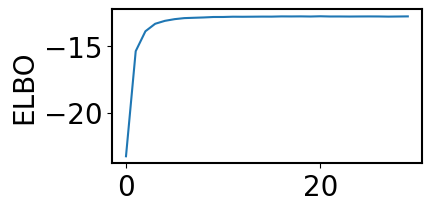

In [21]:
plt.figure(figsize=(4,2))
plt.plot(elbos);
plt.ylabel('ELBO');

#### GMM

In [22]:
train = advi_data_loader.train_ids
test = advi_data_loader.test_ids

In [23]:
spike_train = np.concatenate(trials)
spike_times = spike_train[:,0]
spike_labels = gmm.predict(spike_train[:,2:])
spike_probs = gmm.predict_proba(spike_train[:,2:])

vanilla_gmm = np1_data_loader.prepare_decoder_input(
    np.c_[spike_times, spike_labels, spike_probs],
    is_gmm = True, n_t_bins = 30, regional = True)
print(vanilla_gmm.shape)

(230, 43, 30)


In [24]:
y_train, y_test, y_pred, _, _ = static_decoder(vanilla_gmm, advi_data_loader.behavior, train, test)

lr accuracy: 0.870


#### multi-unit thresholding

In [25]:
spike_channels = spike_train[:,1]

thresholded = np1_data_loader.prepare_decoder_input(
    np.c_[spike_times, spike_channels],
    is_gmm = False, n_t_bins = 30, regional = True)
print(thresholded.shape)

(230, 32, 30)


In [26]:
y_train, y_test, _, _, _ = static_decoder(thresholded, advi_data_loader.behavior, train, test)

lr accuracy: 0.891


#### encoding MoG

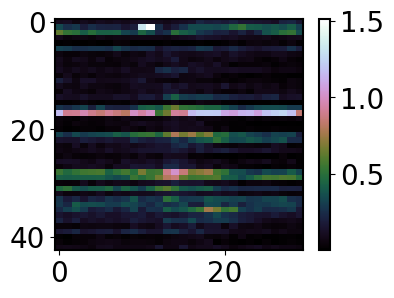

In [27]:
enc_pis, enc_all = advi.encode_gmm(
    advi_data_loader.trials, 
    train, test, y_train, y_pred)

plt.figure(figsize=(4,3))
plt.imshow(enc_all.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

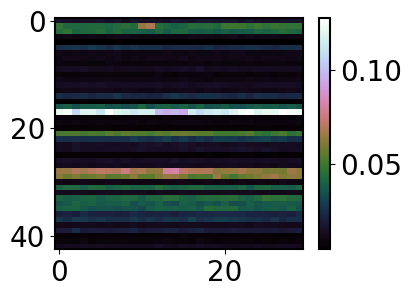

In [28]:
plt.figure(figsize=(4,3))
plt.imshow(enc_pis.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

In [29]:
_, _, _, _, _ = static_decoder(enc_all, advi_data_loader.behavior, train, test)

lr accuracy: 0.913


#### KS all units

In [30]:
ks_all = np1_data_loader.load_all_units(region=region)
ks_all = np.concatenate(ks_all)

all_units = np1_data_loader.prepare_decoder_input(
    ks_all, is_gmm = False, n_t_bins = 30, regional = True)
print(all_units.shape)

Found 74 KS units in region lp
(230, 73, 30)


In [31]:
_, _, _, _, _ = static_decoder(all_units, advi_data_loader.behavior, train, test)

lr accuracy: 0.913


#### KS good units

In [32]:
ks_good = np1_data_loader.load_good_units(region=region)
ks_good = np.concatenate(ks_good)

good_units = np1_data_loader.prepare_decoder_input(
    ks_good, is_gmm = False, n_t_bins = 30, regional = True)
print(good_units.shape)

Found 17 good units in region lp
(230, 17, 30)


In [33]:
_, _, _, _, _ = static_decoder(good_units, advi_data_loader.behavior, train, test)

lr accuracy: 0.696
